# Exploration Data Analysis (EDA)

In [5]:
%pip install torch torchvision torchaudio

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/b1/1a/64f5769025db846a82567fa5b7d21dba4558a7234ee631712ee4771c436c/torch-2.9.1-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/69/98/16e583f59f86cd59949f59d52bfa8fc286f86341a229a9d15cbe7a694f0c/torchvision-0.24.1-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for torchaudio from https://files.pythonhosted.org/packages/2e/7c/df90eb0b337cbad59296ed91778e32be069330f5186256d4ce9ea603d324/torchaudio-2.9.1-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/76/91/7216b27286936c16f5b4d0c530087e4a54eead683e6b0b73dd0c64844af6/filelock-3.20.0-py3-none-any.whl.metadata
  Obtaining dependency information for sympy>=1.13.3 from https://files.pythonhosted.org/packages/a2/09/77d55d46fd61b4a135c444fc97158ef34a095e5681d0a6c10b75bf35619


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import sys
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import torch
import torchvision.transforms as transforms

sys.path.append(os.path.abspath(os.path.join('..', './')))

try:
    import config
    from data import get_dataset_statistics, get_train_transforms
    print(f"Modul berhasil dimuat. Menggunakan device: {config.DEVICE}")
except ImportError as e:
    print("Error import modul. Pastikan file config.py dan data.py ada di folder sebelumnya.")
    print(e)

# Setup visualisasi
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

Modul berhasil dimuat. Menggunakan device: cpu


## 1. Dataset Overview & Distribution

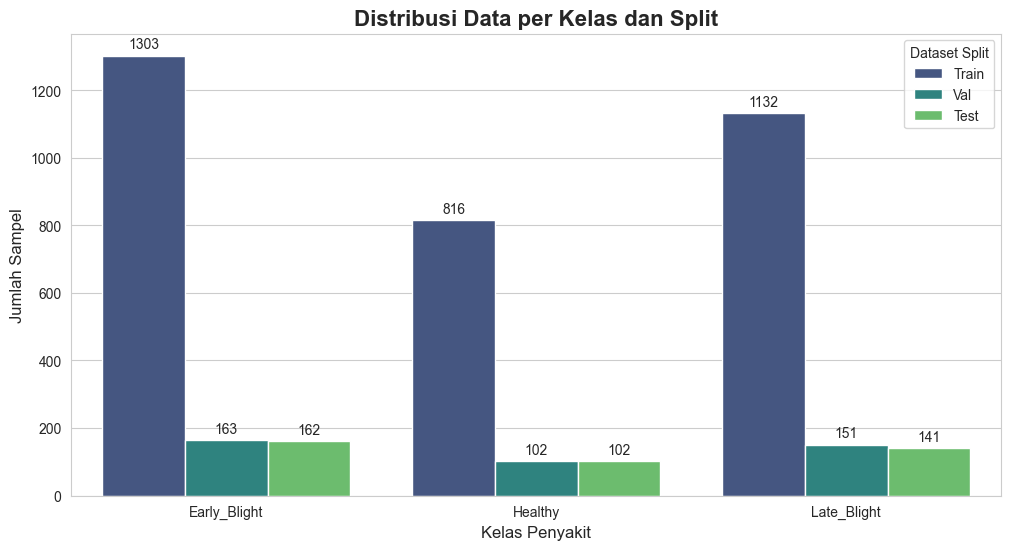

Total Sampel: 4072
Ratio Max/Min Data Imbalance: 1.60


In [20]:
# Mengambil statistik dataset
stats = get_dataset_statistics()

# Membuat DataFrame untuk visualisasi yang lebih mudah
df_dist = pd.DataFrame({
    'Class': stats['class_names'],
    'Train': [stats['train_distribution'][c] for c in stats['class_names']],
    'Val': [stats['val_distribution'][c] for c in stats['class_names']],
    'Test': [stats['test_distribution'][c] for c in stats['class_names']]
})

# Melt dataframe untuk plotting grouped bar chart
df_melted = df_dist.melt(id_vars='Class', var_name='Split', value_name='Count')

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_melted, x='Class', y='Count', hue='Split', palette='viridis')

# Menambahkan label angka di atas bar
for container in ax.containers:
    ax.bar_label(container, padding=3)

plt.title('Distribusi Data per Kelas dan Split', fontsize=16, fontweight='bold')
plt.xlabel('Kelas Penyakit', fontsize=12)
plt.ylabel('Jumlah Sampel', fontsize=12)
plt.legend(title='Dataset Split')
plt.show()

print(f"Total Sampel: {stats['total_size']}")
# Cek Imbalance
min_cls = df_dist['Train'].min()
max_cls = df_dist['Train'].max()
ratio = max_cls / min_cls
if ratio > 1.5:
    print(f"Ratio Max/Min Data Imbalance: {ratio:.2f}")
else:
    print(f"Dataset relatif seimbang (Ratio Max/Min: {ratio:.2f})")

## 2. Visual Gallery per Class

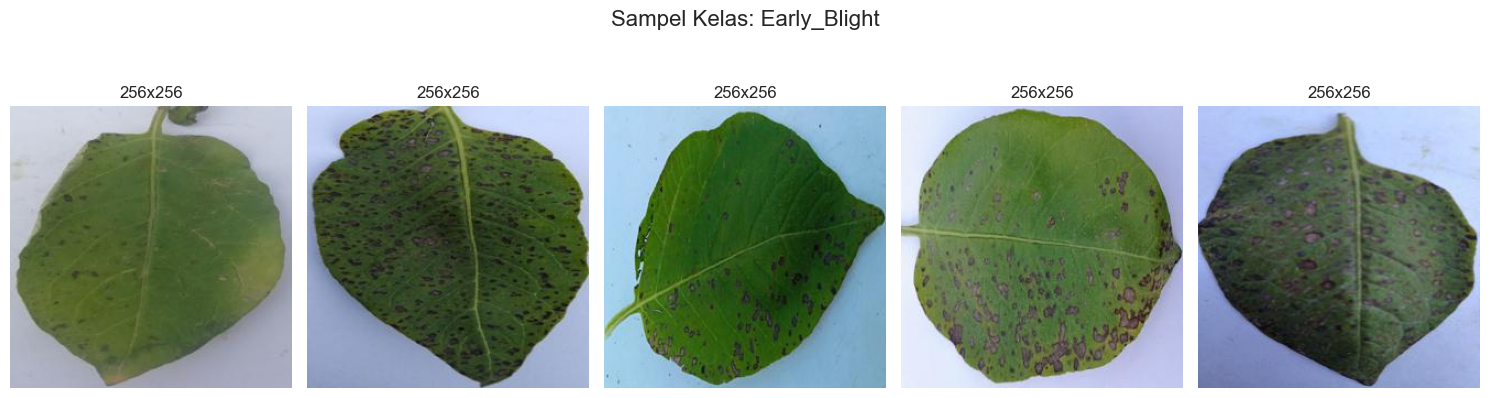

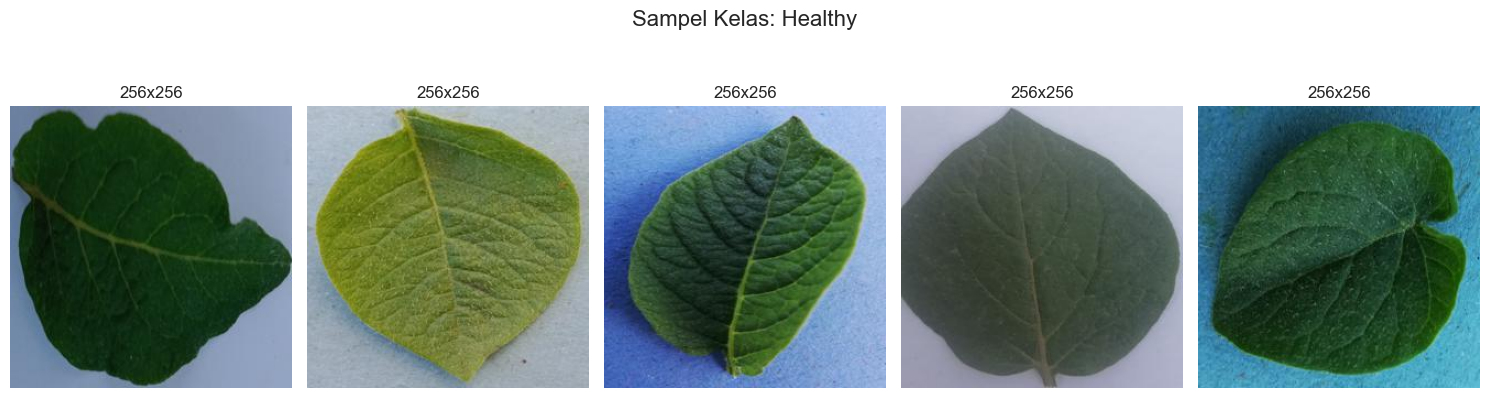

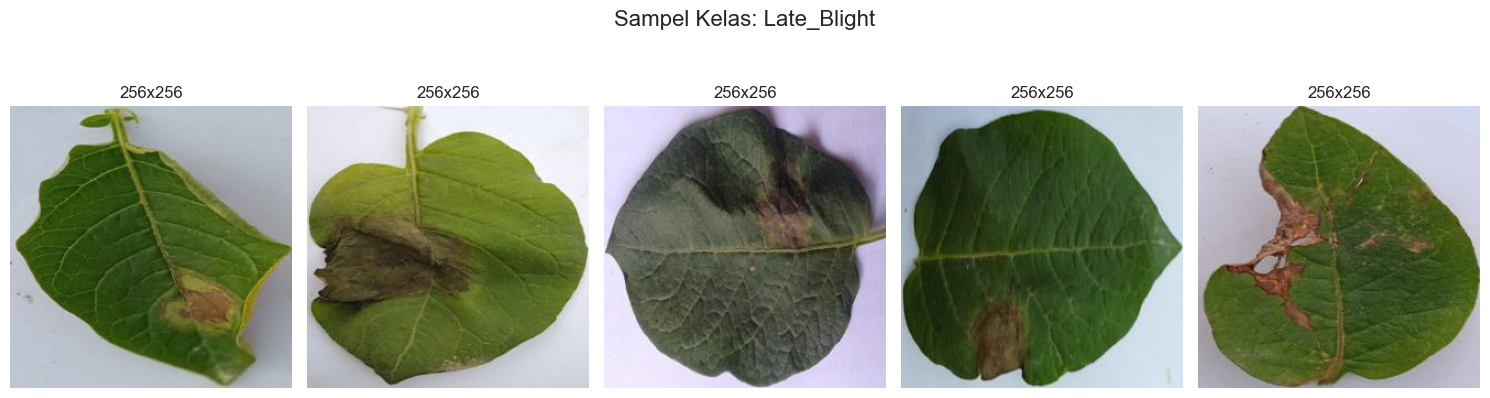

In [21]:
def visualize_class_samples(class_name, num_samples=5):
    class_dir = config.TRAIN_DIR / class_name
    images = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png')) + list(class_dir.glob('*.jpeg'))
    
    if not images:
        print(f"Tidak ada gambar untuk kelas {class_name}")
        return

    samples = random.sample(images, min(len(images), num_samples))
    
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 4))
    fig.suptitle(f"Sampel Kelas: {class_name}", fontsize=16, y=1.05)
    
    for i, img_path in enumerate(samples):
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"{img.size[0]}x{img.size[1]}") # Tampilkan resolusi asli

    plt.tight_layout()
    plt.show()

# Loop untuk menampilkan semua kelas
for cls in config.CLASS_NAMES:
    visualize_class_samples(cls)

## 3. Color Distribution Analysis (RGB Histograms)

Menganalisis distribusi warna per kelas...


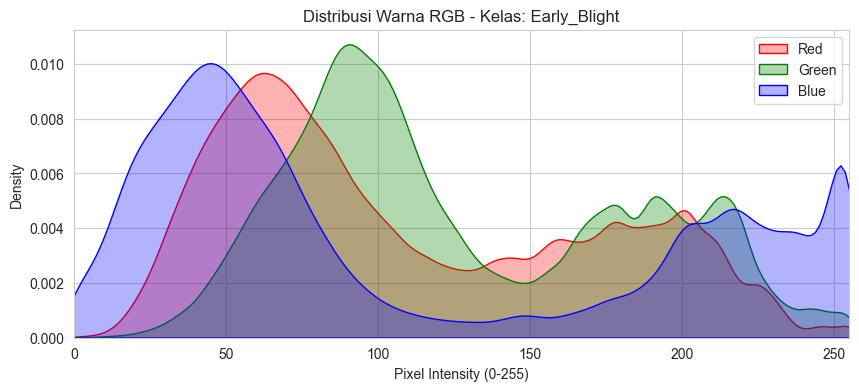

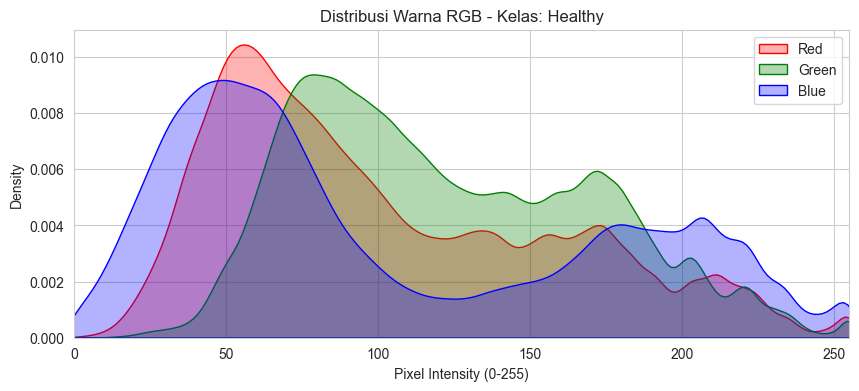

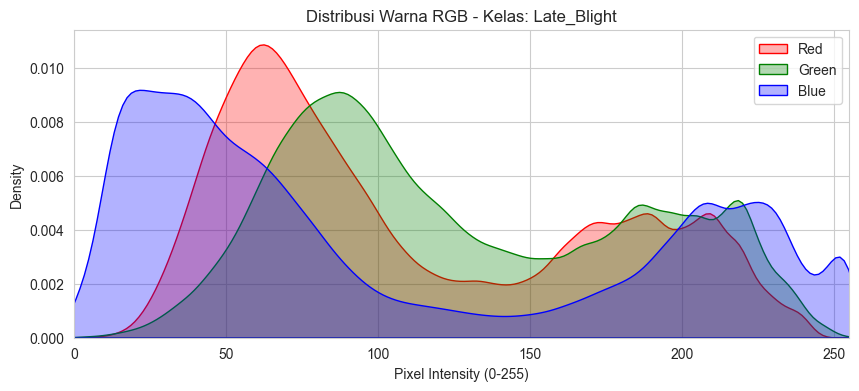

In [23]:
def plot_color_histogram(class_name):
    class_dir = config.TRAIN_DIR / class_name
    images = list(class_dir.glob('*'))
    samples = random.sample(images, min(len(images), 50)) # Ambil 50 sampel
    
    red_vals = []
    green_vals = []
    blue_vals = []
    
    for img_path in samples:
        img = Image.open(img_path).convert('RGB')
        img_np = np.array(img)
        red_vals.extend(img_np[:, :, 0].flatten())
        green_vals.extend(img_np[:, :, 1].flatten())
        blue_vals.extend(img_np[:, :, 2].flatten())
        
    plt.figure(figsize=(10, 4))
    sns.kdeplot(red_vals, color='red', fill=True, label='Red', alpha=0.3)
    sns.kdeplot(green_vals, color='green', fill=True, label='Green', alpha=0.3)
    sns.kdeplot(blue_vals, color='blue', fill=True, label='Blue', alpha=0.3)
    
    plt.title(f'Distribusi Warna RGB - Kelas: {class_name}')
    plt.xlabel('Pixel Intensity (0-255)')
    plt.xlim(0, 255)
    plt.legend()
    plt.show()

# Tampilkan histogram untuk setiap kelas
print("Menganalisis distribusi warna per kelas...")
for cls in config.CLASS_NAMES:
    plot_color_histogram(cls)

## 4. Visualisasi Sampel Data (Batch Viewer)

Batch Shape: torch.Size([9, 3, 224, 224])
Label Shape: torch.Size([9])


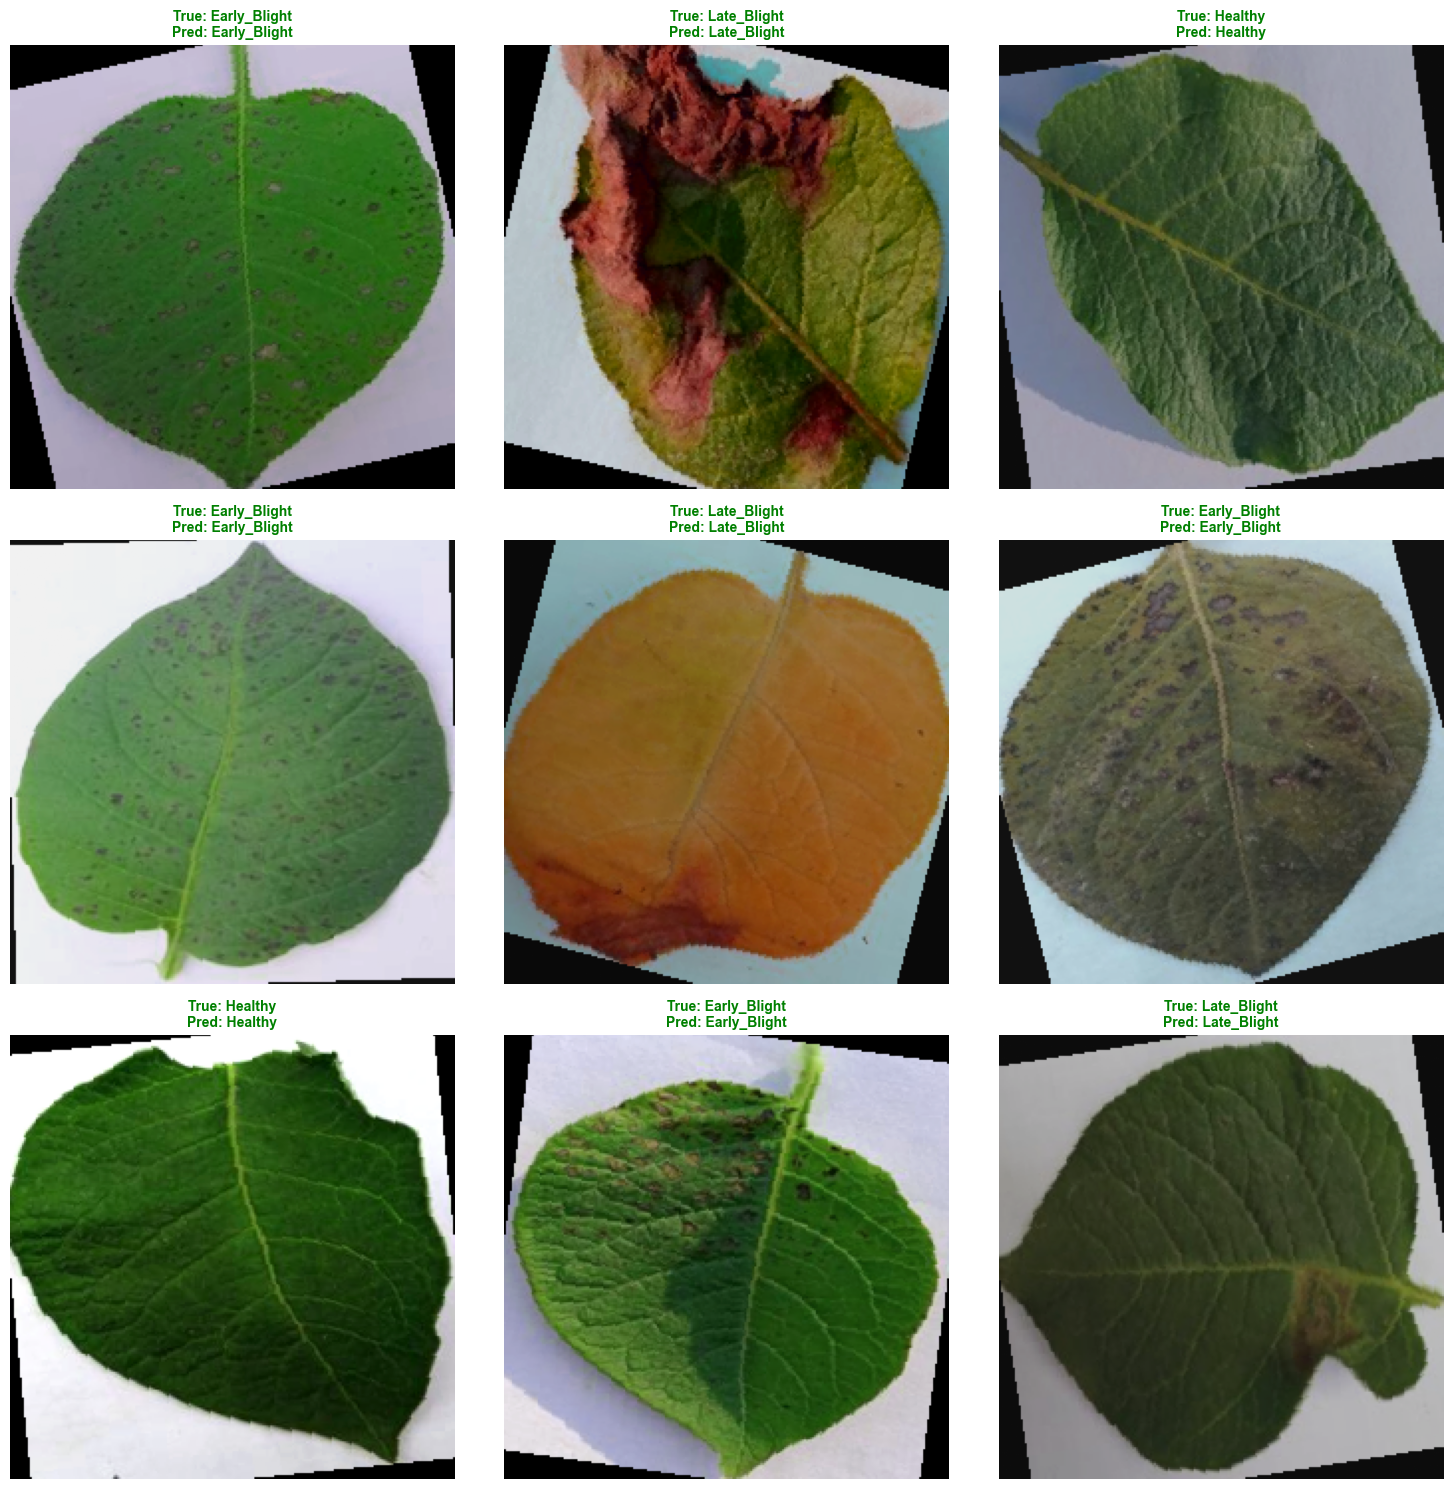

In [15]:
# Membuat DataLoader (hanya untuk visualisasi, matikan shuffle agar konsisten jika perlu)
try:
    train_loader, _, _ = create_dataloaders(batch_size=9)
    
    # Ambil 1 batch
    images, labels = next(iter(train_loader))
    
    print(f"Batch Shape: {images.shape}")
    print(f"Label Shape: {labels.shape}")
    
    # Gunakan fungsi plotting dari utils.py
    # Kita passing labels sebagai prediksi juga untuk melihat ground truth
    plot_sample_predictions(
        images=images,
        true_labels=labels,
        pred_labels=labels, # Mock prediction (sama dengan true label)
        class_names=config.CLASS_NAMES,
        num_samples=9
    )
    
except Exception as e:
    print(f"Gagal memuat DataLoader: {e}")

## 5. Data Augmentation Preview

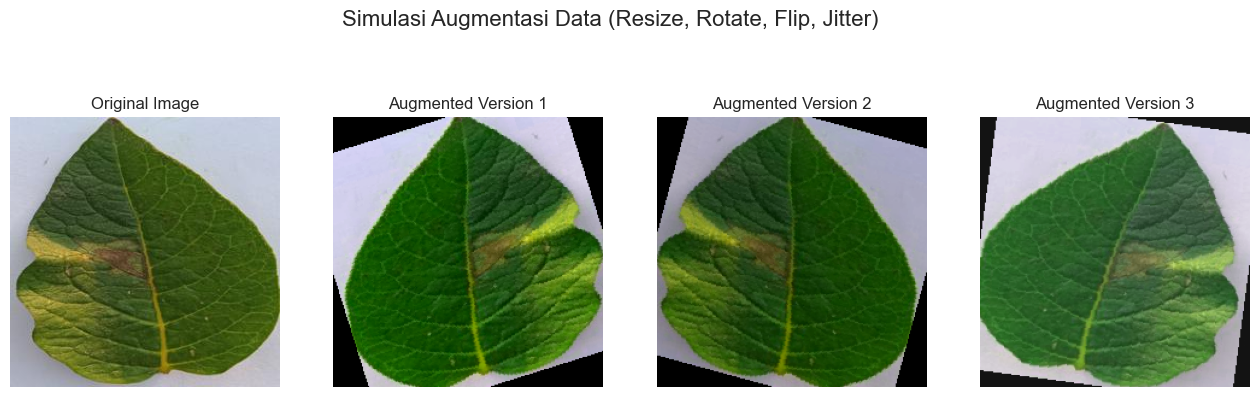

In [25]:
# Ambil transform pipeline
train_transform = get_train_transforms()

# Fungsi untuk denormalize agar gambar bisa dilihat normal kembali (opsional, untuk visualisasi)
def denormalize(tensor):
    mean = torch.tensor(config.IMAGENET_MEAN).view(3, 1, 1)
    std = torch.tensor(config.IMAGENET_STD).view(3, 1, 1)
    return tensor * std + mean

# Ambil 1 gambar random
sample_img_path = random.choice(list(config.TRAIN_DIR.glob('*/*.jpg')))
raw_image = Image.open(sample_img_path).convert('RGB')

# Plot
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

# Gambar Asli
axes[0].imshow(raw_image)
axes[0].set_title("Original Image")
axes[0].axis('off')

# 3 Contoh Augmentasi dari gambar yang sama
for i in range(1, 4):
    # Apply transform (hasilnya Tensor)
    aug_tensor = train_transform(raw_image)
    
    # Denormalize untuk visualisasi yang enak dilihat
    view_img = denormalize(aug_tensor)
    
    # Convert tensor ke numpy (HWC format)
    view_img = view_img.permute(1, 2, 0).numpy()
    view_img = np.clip(view_img, 0, 1) # Clip agar valid range 0-1
    
    axes[i].imshow(view_img)
    axes[i].set_title(f"Augmented Version {i}")
    axes[i].axis('off')

plt.suptitle(f"Simulasi Augmentasi Data (Resize, Rotate, Flip, Jitter)", fontsize=16)
plt.show()